In [1]:
import pandas as pd
import os

current_path = os.getcwd()

train_file = os.path.join(current_path, "data/train")  # 训练集文件夹
val_file = os.path.join(current_path, "data/val")  # 验证集文件夹

train_audio = os.path.join(train_file, "audio_train")  # 训练集音频文件夹
val_audio = os.path.join(val_file, "audio_val")  # 验证集音频文件夹

train_scale_file = os.path.join(train_file, "audio_scale_train.xlsx")  # 训练集音频标签文件
val_scale_file = os.path.join(val_file, "audio_scale_val.xlsx")  # 验证集音频标签文件

feature_file = os.path.join(current_path, "features")  # 特征文件夹

saved_model_file = os.path.join(current_path, "saved_model/best.pth")  # 保存模型文件

In [2]:
import opensmile

# 提取音频特征
def extract_audio_feature(input_file, feature_file, mode):
    wav_vad_files = os.listdir(input_file)

    smile = opensmile.Smile(
        feature_set=opensmile.FeatureSet.ComParE_2016,
        feature_level=opensmile.FeatureLevel.Functionals,
    )

    if mode == "train":
        ComParE_2016_Functionals_feature_path = os.path.join(feature_file, "ComParE_2016_Functionals_train_features.csv")
    elif mode == "val":
        ComParE_2016_Functionals_feature_path = os.path.join(feature_file, "ComParE_2016_Functionals_val_features.csv")


    count = 0
    for wav_vad in wav_vad_files:
        wav_vad_path = os.path.join(input_file, wav_vad)
        # print(wav_vad_path)
        feature = smile.process_file(wav_vad_path)
        
        if count == 0:
            feature.to_csv(ComParE_2016_Functionals_feature_path, mode='a', index=False)
        else:
            feature.to_csv(ComParE_2016_Functionals_feature_path, mode='a', header=False, index=False)
        count += 1

# extract_audio_feature(input_file=train_audio, feature_file=feature_file, mode="train")
# extract_audio_feature(input_file=val_audio, feature_file=feature_file, mode="val")

In [3]:
from torch.utils.data import Dataset, DataLoader

class AudioDataset(Dataset):
    def __init__(self, feature_file, label_file, scaler=None, transform=None):
        self.feature_file = feature_file
        self.label_file = label_file
        self.scaler = scaler
        self.labels = self.load_annotations()
        self.features = self.load_features()
        self.transform = transform

    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        feature = self.features[idx]
        label = self.labels[idx]
        if self.transform:
            feature = self.transform(feature)
        return feature, label

    def load_annotations(self):
        df = pd.read_excel(self.label_file)

        # 提取特定的列
        column1 = df['量表完成时间']
        column2 = df['联系电话']
        column3 = df['抑郁得分']

        # 将两列数据拼接在一起
        concatenated_columns = pd.concat([column1, column2, column3], axis=1)

        audio_name = []
        labels = []
        for index, row in concatenated_columns.iterrows():
            audio_name.append(str(row['联系电话']) + '_' + row['量表完成时间'].replace('-', '_') + '.amr')
            labels.append(0 if row['抑郁得分'] < 5 else 1)
        return labels
    
    def load_features(self):
        # 读取 CSV 文件
        df = pd.read_csv(self.feature_file)
        scaled_features = self.scaler.transform(df)  # 对数据进行标准化

        # 将每一行作为一个列表
        rows_as_lists = scaled_features.tolist()  #scledr之后

        return rows_as_lists


In [4]:
from sklearn.preprocessing import StandardScaler

# features = pd.read_csv(os.path.join(feature_file, "ComParE_2016_Functionals_train_features.csv"))

# features = pd.read_csv(os.path.join(feature_file, "eGeMAPSv02_Functionals_train_features.csv"))

# features = pd.read_csv(os.path.join(feature_file, "emobase_Functionals_train_features.csv"))

# features = pd.read_csv(os.path.join(feature_file, "all_train_features.csv"))

features = pd.read_csv(os.path.join(feature_file, "significant_train_feature_151.csv"))

scaler = StandardScaler()
scaler.fit(features)

StandardScaler()

In [5]:
# train_dataset = AudioDataset(feature_file=os.path.join(feature_file, "ComParE_2016_Functionals_train_features.csv"), 
#                              label_file=train_scale_file, 
#                              scaler=scaler)
# val_dataset = AudioDataset(feature_file=os.path.join(feature_file, "ComParE_2016_Functionals_val_features.csv"), 
#                            label_file=val_scale_file, 
#                            scaler=scaler)

# train_dataset = AudioDataset(feature_file=os.path.join(feature_file, "eGeMAPSv02_Functionals_train_features.csv"), 
#                              label_file=train_scale_file, 
#                              scaler=scaler)
# val_dataset = AudioDataset(feature_file=os.path.join(feature_file, "eGeMAPSv02_Functionals_val_features.csv"), 
#                            label_file=val_scale_file, 
#                            scaler=scaler)

# train_dataset = AudioDataset(feature_file=os.path.join(feature_file, "emobase_Functionals_train_features.csv"), 
#                              label_file=train_scale_file, 
#                              scaler=scaler)
# val_dataset = AudioDataset(feature_file=os.path.join(feature_file, "emobase_Functionals_val_features.csv"), 
#                            label_file=val_scale_file, 
#                            scaler=scaler)

# train_dataset = AudioDataset(feature_file=os.path.join(feature_file, "all_train_features.csv"), 
#                              label_file=train_scale_file, 
#                              scaler=scaler)
# val_dataset = AudioDataset(feature_file=os.path.join(feature_file, "all_val_features.csv"), 
#                            label_file=val_scale_file, 
#                            scaler=scaler)

train_dataset = AudioDataset(feature_file=os.path.join(feature_file, "significant_train_feature_151.csv"), 
                             label_file=train_scale_file, 
                             scaler=scaler)
val_dataset = AudioDataset(feature_file=os.path.join(feature_file, "significant_val_feature_151.csv"), 
                           label_file=val_scale_file, 
                           scaler=scaler)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=True)

len(train_loader), len(val_loader)

(23, 8)

In [6]:
import torch

for inputs, labels in train_loader:
    inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
    print('Feature is: {}'.format(inputs))
    print('Label is: {}'.format(labels))
    break

Feature is: tensor([[-7.0914e-01, -9.1610e-01, -1.1385e+00, -9.0116e-01, -1.0964e+00,
         -5.4404e-01, -1.0150e+00, -1.0110e+00, -8.7843e-01, -8.3658e-01,
         -1.6832e-01, -9.9907e-01, -8.5910e-01, -7.6262e-01, -9.8493e-01,
          1.4940e-01, -8.1244e-01, -9.8431e-01, -8.4265e-01, -7.7153e-01,
          4.4464e-02, -8.4488e-01, -9.7179e-01, -8.1985e-01, -7.3888e-01,
          6.9573e-02, -9.4841e-01, -7.9808e-01, -7.6086e-01,  6.6560e-02,
          1.5111e-01,  3.9436e-01,  1.3273e+00, -6.8563e-01, -5.0779e-01,
         -1.0862e+00, -1.1539e+00, -1.3823e+00, -9.8548e-01, -1.1498e+00,
         -4.7453e-01, -9.8238e-01, -1.0603e+00, -1.1916e+00,  2.0996e-01,
         -8.9151e-01, -4.4499e-01, -5.7226e-01, -8.7107e-01, -4.2826e-01,
         -5.4816e-01, -8.6082e-01, -5.8338e-01, -8.3698e-01, -4.5012e-01,
         -5.3287e-01, -1.4281e-01,  5.0101e-01, -1.0131e+00,  1.3151e+00,
          1.2456e+00,  4.9694e-01,  1.0475e+00, -1.1438e+00,  7.6033e-01,
         -3.4643e-01, -7.0

In [7]:
import torch

dataloaders = {'train':train_loader,'valid':val_loader}

# 是否用GPU训练
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
    
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

CUDA is available!  Training on GPU ...


In [8]:
import torch.nn as nn

class ANNModel(nn.Module):
    def __init__(self):
        super(ANNModel, self).__init__()
        # self.layer1 = nn.Linear(6373, 6373)
        # self.layer2 = nn.Linear(6373, 64)

        # self.layer1 = nn.Linear(88, 88)
        # self.layer2 = nn.Linear(88, 64)

        # self.layer1 = nn.Linear(988, 988)
        # self.layer2 = nn.Linear(988, 64)

        # self.layer1 = nn.Linear(7449, 7449)
        # self.layer2 = nn.Linear(7449, 64)

        self.layer1 = nn.Linear(151, 151)
        self.layer2 = nn.Linear(151, 64)

        self.layer3 = nn.Linear(64, 64)
        self.layer4 = nn.Linear(64, 32)
        self.layer5 = nn.Linear(32, 32)
        self.layer6 = nn.Linear(32, 2)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(p=0.6)


    def forward(self, x):
        x = self.layer1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer2(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer3(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer4(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer5(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.layer6(x)
        return torch.softmax(x, dim=1)

# 实例化模型
model = ANNModel()

In [9]:
# from torchsummary import summary

# summary(model=model, input_size=(151,), device='cpu')

In [10]:
import torch.optim as optim

# 优化器设置
optimizer = optim.AdamW(model.parameters(), lr=0.0005)
# optimizer = optim.Adam(model.parameters(), lr=0.0005)
# optimizer = optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)  # 学习率每step_size个epoch衰减成原来的1/10

# criterion = nn.MSELoss()
# criterion = nn.BCELoss()

criterion = nn.CrossEntropyLoss()

In [11]:
import time
import copy

def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, is_inception=False, filename='best.pth'):
    since = time.time()
    best_acc = 0
    model.to(device)

    val_acc_history = []
    train_acc_history = []
    train_losses = []
    valid_losses = []

    LRs = [optimizer.param_groups[0]['lr']]

    best_model_wts = copy.deepcopy(model.state_dict())

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 训练和验证
        for phase in ['train', 'valid']:
            if phase == 'train':
                model.train()  # 训练
            else:
                model.eval()   # 验证

            running_loss = 0.0
            running_corrects = 0

            # 把数据都取个遍
            for inputs, labels in dataloaders[phase]:
                inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 清零
                optimizer.zero_grad()
                # 只有训练的时候计算和更新梯度
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    # preds = torch.round(outputs)
                    _, preds = torch.max(outputs.float(), 1)

                    # 训练阶段更新权重
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 计算损失
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            
            
            time_elapsed = time.time() - since
            print('Time elapsed {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            

            # 得到最好那次的模型
            if phase == 'valid' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                state = {
                  'state_dict': model.state_dict(),  #字典里key就是各层的名字，值就是训练好的权重
                  'best_acc': best_acc,
                  'optimizer' : optimizer.state_dict(),  #优化器的状态信息
                }
                torch.save(state, filename)
                # 计算混淆矩阵
                model_preds = []
                true_labels = []
                model_probs = []  # 模型预测的对应正确标签的概率
                for inputs, labels in dataloaders['valid']:
                    inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        model_preds.extend(preds)
                        true_labels.extend(labels)
                        # print('labels', labels.cpu())
                        # print('outputs', outputs.cpu())
                        # print('preds', preds.cpu())
                        probability = outputs.gather(1, labels.view(-1, 1)).squeeze()
                        # print('probability', probability)
                        # 取出模型预测的对应正确标签的概率
                        model_probs.extend(probability)

                        # model_probs.extend(outputs[:, labels].cpu().numpy())  # 取出模型预测的对应正确标签的概率
                val_model_preds = model_preds
                val_true_labels = true_labels
                val_model_probs = model_probs

                model_preds = []
                true_labels = []
                model_probs = []
                for inputs, labels in dataloaders['train']:
                    inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
                    inputs = inputs.to(device)
                    labels = labels.to(device)
                    with torch.no_grad():
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        model_preds.extend(preds)
                        true_labels.extend(labels)
                        probability = outputs.gather(1, labels.view(-1, 1)).squeeze()
                        model_probs.extend(probability)

                train_model_preds = model_preds
                train_true_labels = true_labels
                train_model_probs = model_probs

            if phase == 'valid':
                val_acc_history.append(epoch_acc)
                valid_losses.append(epoch_loss)
                scheduler.step(epoch_loss)  #学习率衰减
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_losses.append(epoch_loss)
        
        print('Optimizer learning rate : {:.7f}'.format(optimizer.param_groups[0]['lr']))
        LRs.append(optimizer.param_groups[0]['lr'])
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 训练完后用最好的一次当做模型最终的结果,等着一会测试
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, train_acc_history, valid_losses, train_losses, LRs, val_model_preds, val_true_labels, train_model_preds, train_true_labels, val_model_probs, train_model_probs

In [12]:
model_ft, val_acc_history, train_acc_history, valid_losses, train_losses, LRs, val_model_preds, val_true_labels, train_model_preds, train_true_labels, val_model_probs, train_model_probs  = train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=200, filename=saved_model_file)

Epoch 0/199
----------
Time elapsed 0m 0s
train Loss: 0.6700 Acc: 0.6630
Time elapsed 0m 0s
valid Loss: 0.6797 Acc: 0.6000
Optimizer learning rate : 0.0005000

Epoch 1/199
----------


d:\miniconda3\envs\speech_Depression\lib\site-packages\torch\optim\lr_scheduler.py:156: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Time elapsed 0m 1s
train Loss: 0.6717 Acc: 0.6739
Time elapsed 0m 1s
valid Loss: 0.6786 Acc: 0.6000
Optimizer learning rate : 0.0005000

Epoch 2/199
----------
Time elapsed 0m 1s
train Loss: 0.6627 Acc: 0.6739
Time elapsed 0m 1s
valid Loss: 0.6776 Acc: 0.6000
Optimizer learning rate : 0.0005000

Epoch 3/199
----------
Time elapsed 0m 1s
train Loss: 0.6640 Acc: 0.6739
Time elapsed 0m 1s
valid Loss: 0.6769 Acc: 0.6000
Optimizer learning rate : 0.0005000

Epoch 4/199
----------
Time elapsed 0m 1s
train Loss: 0.6615 Acc: 0.6739
Time elapsed 0m 1s
valid Loss: 0.6761 Acc: 0.6000
Optimizer learning rate : 0.0005000

Epoch 5/199
----------
Time elapsed 0m 1s
train Loss: 0.6580 Acc: 0.6739
Time elapsed 0m 1s
valid Loss: 0.6754 Acc: 0.6000
Optimizer learning rate : 0.0005000

Epoch 6/199
----------
Time elapsed 0m 1s
train Loss: 0.6592 Acc: 0.6739
Time elapsed 0m 1s
valid Loss: 0.6743 Acc: 0.6000
Optimizer learning rate : 0.0005000

Epoch 7/199
----------
Time elapsed 0m 1s
train Loss: 0.6539 Ac

In [13]:
train_acc_history = [t.item() for t in train_acc_history]
val_acc_history = [t.item() for t in val_acc_history]

val_model_preds = [t.item() for t in val_model_preds]
val_true_labels = [t.item() for t in val_true_labels]

train_model_preds = [t.item() for t in train_model_preds]
train_true_labels = [t.item() for t in train_true_labels]

train_model_probs = [t.item() for t in train_model_probs]
val_model_probs = [t.item() for t in val_model_probs]

model_preds = train_model_preds + val_model_preds
true_labels = train_true_labels + val_true_labels
model_probs = train_model_probs + val_model_probs

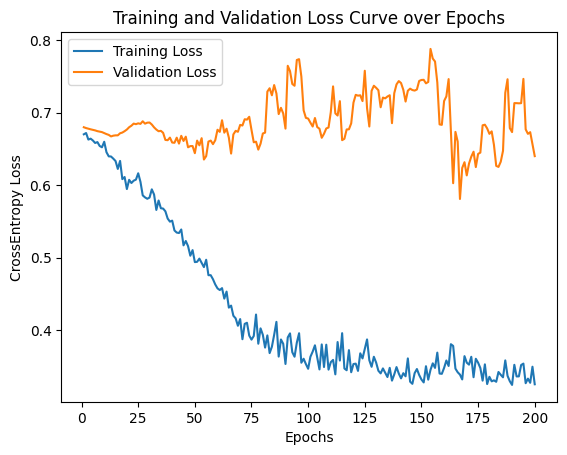

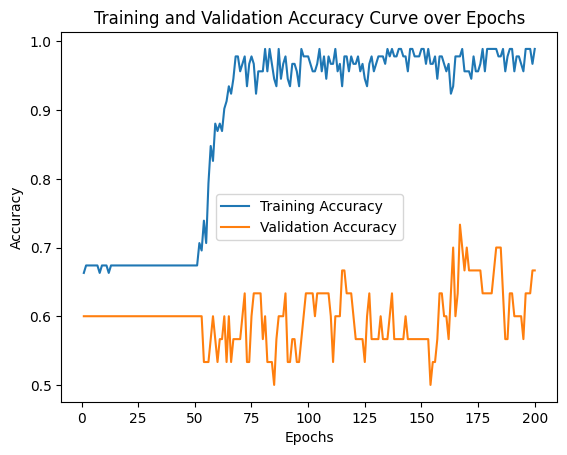

In [14]:
import matplotlib.pyplot as plt

def plot_loss_curve(train_history, val_history):
    """
    绘制训练集和验证集曲线

    Parameters:
        train_history (list): 训练集每个 epoch 的 结果 列表
        val_history (list): 验证集每个 epoch 的 结果 列表

    Returns:
        None
    """
    epochs = range(1, len(train_history) + 1)
    
    # 绘制训练集和验证集的 结果 曲线
    plt.plot(epochs, train_history, label='Training Loss')
    plt.plot(epochs, val_history, label='Validation Loss')
    
    plt.xlabel('Epochs')
    plt.ylabel('CrossEntropy Loss')
    plt.title('Training and Validation Loss Curve over Epochs')
    plt.legend()
    plt.show()

def plot_acc_curve(train_history, val_history):
    """
    绘制训练集和验证集曲线

    Parameters:
        train_history (list): 训练集每个 epoch 的 结果 列表
        val_history (list): 验证集每个 epoch 的 结果 列表

    Returns:
        None
    """
    epochs = range(1, len(train_history) + 1)
    
    # 绘制训练集和验证集的 结果 曲线
    plt.plot(epochs, train_history, label='Training Accuracy')
    plt.plot(epochs, val_history, label='Validation Accuracy')
    
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy Curve over Epochs')
    plt.legend()
    plt.show()

plot_loss_curve(train_losses, valid_losses)
plot_acc_curve(train_acc_history, val_acc_history)

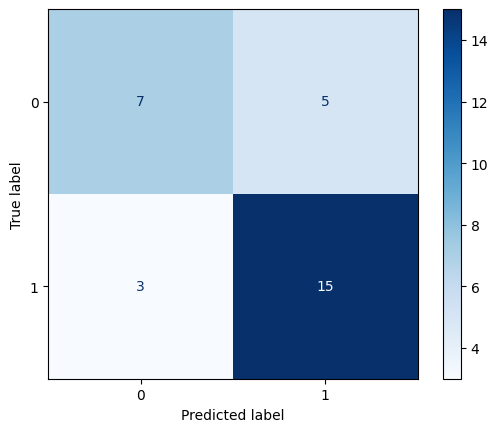

In [15]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(val_true_labels, val_model_preds)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])  # 显示标签
disp.plot(cmap=plt.cm.Blues)  # 使用蓝色配色方案
plt.show()

In [16]:
# 从混淆矩阵中提取TP, TN, FP, FN
TP = cm[0, 0]
TN = cm[1, 1]
FP = cm[1, 0]
FN = cm[0, 1]

# 计算准确率(Accuracy)、精确率(Precision)、召回率 (Recall)、特异度(Specificity)、F1值(F1 Score)
accuracy = (TP + TN) / float(TP + TN + FP + FN)
precision = TP / float(TP + FP)
recall = TP / float(TP + FN)
specificity = TN / float(TN + FP)
f1 = 2 * precision * recall / (precision + recall)


print(f'Accuracy: {accuracy:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'Specificity: {specificity:.5f}')
print(f'F1 Score: {f1:.5f}')


Accuracy: 0.73333
Precision: 0.70000
Recall: 0.58333
Specificity: 0.83333
F1 Score: 0.63636


In [17]:
from sklearn.metrics import roc_auc_score

roc_auc = roc_auc_score(val_true_labels, val_model_probs)
print(f'AUC: {roc_auc:.4f}')

AUC: 0.8102


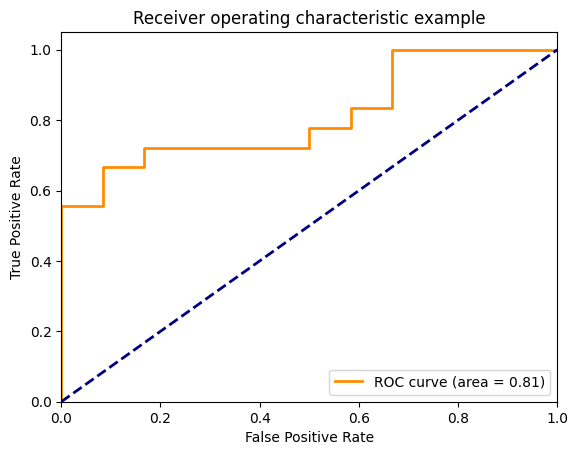

In [18]:
# 绘制ROC曲线图
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(val_true_labels, val_model_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()


In [19]:
# checkpoint = torch.load(r'D:\Projects\Speech_Depression\saved_model\best.pth')
# model.load_state_dict(checkpoint['state_dict'])

# for inputs, labels in val_loader:
#     inputs = torch.stack(inputs, dim=1, out=None).squeeze(0).float()
#     # print('Input is: {}'.format(inputs))
#     print('Label is: {}'.format(labels))

#     model.eval()

#     if train_on_gpu:
#         output = model(inputs.cuda())
#     else:
#         output = model(inputs)

#     output = torch.argmax(output, 1)

#     print('Output is: {}'.format(output))

#     break